test các hàm cơ bản xem chạy như nào

In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

tạo bounding box trên labels_new: ở tập train của labels có 5 chỉ số, chỉ focus vào 4 chỉ số sau: x, y, w, h trong đó (x, y) là tọa độ tâm của chữ. Ở labels_new: (x, y) là tọa độ góc trái trên

In [3]:
# READ IMAGES IN COLORED FORMAT
def read_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# PLOT BB TO DEBUG
def plot_BB(image_path, coord_path):
    image = read_image(image_path)

    with open(coord_path, "r") as f:
        coordinates = [line.strip().split()[1:] for line in f.readlines()]

    plt.imshow(image)
    for coord in coordinates:
        # Split the coordinates
        x_upper_left, y_upper_left, x_below_right, y_below_right = map(float, coord)
        x = x_upper_left
        y = y_upper_left
        w = x_below_right - x_upper_left
        h = y_below_right - y_upper_left
        # Scale the coordinates to the image dimensions
        x *= image.shape[1]
        y *= image.shape[0]
        w *= image.shape[1]
        h *= image.shape[0]
        # Convert coordinates to integers
        x, y, w, h = map(int, (x, y, w, h))

        rect_box = plt.Rectangle((x, y), w, h, color='red', fill=False, lw=3)
        plt.gca().add_patch(rect_box)


In [ ]:
img_dir = "wb_localization_dataset/images/train/nlvnpf-0137-01-001.jpg"
coord_dir = "wb_localization_dataset/labels/train/nlvnpf-0137-01-001.txt"
plot_BB(img_dir, coord_dir)

Xem data của 1 ảnh với 5 trường dữ liệu: x, y, w, h, area

In [8]:
#xem data trên 1 ảnh
def cal_pic_statics(coord_path):
  with open(coord_path, "r") as f:
      coordinates = [line.strip().split()[1:] for line in f.readlines()]

  pic_dat = []
  for coord in coordinates:
      # Split the coordinates
      x_upper_left, y_upper_left, x_below_right, y_below_right = map(float, coord)
      x = x_upper_left
      y = y_upper_left
      w = x_below_right - x_upper_left
      h = y_below_right - y_upper_left
      area = h * w
      char_dat = [x, y, w, h, area]
      pic_dat.append(char_dat)
  return np.array(pic_dat)


pic_data = cal_pic_statics("labels_new/train/nlvnpf-0137-01-001.txt")
print(pic_data.shape)

(149, 5)


Data tất cả các ảnh
hàm này sẽ trả về 5 cái variance ứng với 5 loại x, y, w, h, area của từng ảnh. Mỗi row sẽ chứa variance của từng ảnh
variance: phương sai

In [10]:
#hàm này sẽ trả về 5 cái variance ứng với 5 loại x, y, w, h, area. Mỗi row sẽ chứa variance của từng ảnh
def cal_labels_statis(labels_folder):
  overall_statis = []
  for filename in os.listdir(labels_folder):
    if filename.endswith(".txt"):
        label_file = os.path.join(labels_folder, filename)
        with open(label_file, "r") as f:
            coordinates = [line.strip().split()[1:] for line in f.readlines()]
            pic_dat = []
            for coord in coordinates:
                # Split the coordinates
                x_upper_left, y_upper_left, x_below_right, y_below_right = map(float, coord)
                x = x_upper_left
                y = y_upper_left
                w = x_below_right - x_upper_left
                h = y_below_right - y_upper_left
                area = h * w

                char_dat = [x, y, w, h, area]
                pic_dat.append(char_dat)
            pic_dat = np.array(pic_dat)

            #Cal statistical values - variance
            x_dis = pic_dat[:, 0]
            x_var = np.var(x_dis)

            y_dis = pic_dat[:, 1]
            y_var = np.var(y_dis)

            s_w = pic_dat[:, 2]
            w_var = np.var(s_w)

            s_h = pic_dat[:, 3]
            h_var = np.var(s_h)

            s_area = pic_dat[:, 4]
            area_var = np.var(s_area)

            pic_var = [x_var, y_var, w_var, h_var, area_var]
            overall_statis.append(pic_var)
  return np.array(overall_statis)

label_stat = cal_labels_statis("labels_new/train")
print(label_stat.shape)

(70, 5)


In [11]:
# Create the index column
index_col = np.arange(label_stat.shape[0])
# Add the index column to the array
label_stat = np.column_stack((index_col, label_stat))

print(label_stat.shape)

(70, 6)


Đồ thị biểu diễn phương sai của x, y, w, h, area qua từng ảnh.
trục x: thứ tự các ảnh
trục y: phương sai ứng với ảnh đó

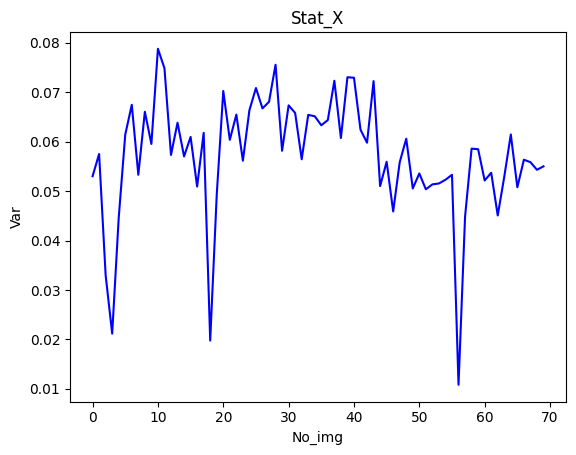

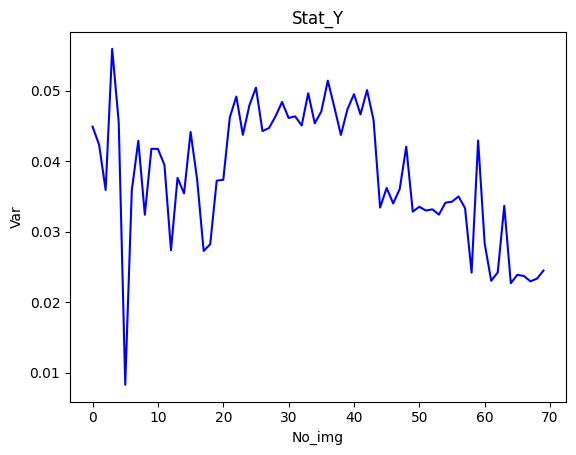

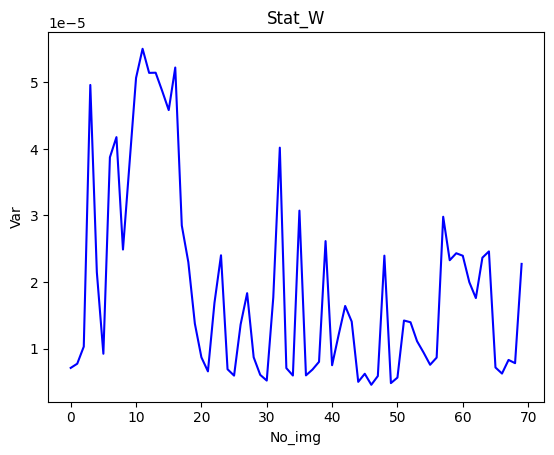

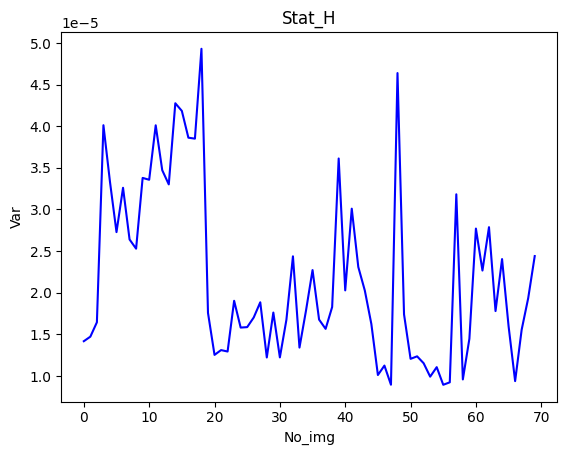

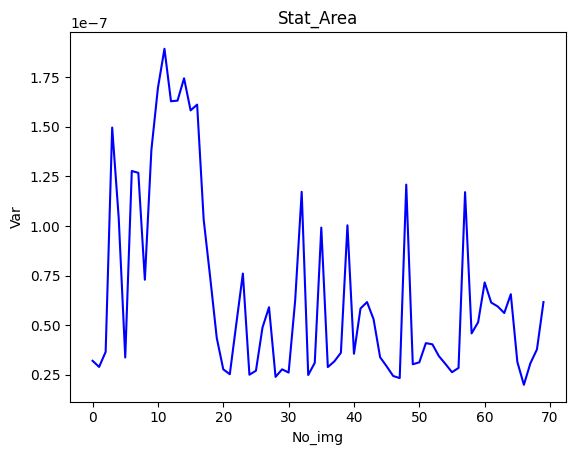

In [16]:
# Plotting multiple lines on a single plot
plt.plot(label_stat[:, 0], label_stat[:, 1], color='b')

# Adding labels and title
plt.xlabel('No_img')
plt.ylabel('Var')
plt.title('Stat_X')

# Displaying the legend and the plot
plt.show()

plt.plot(label_stat[:, 0], label_stat[:, 2], color='b')
plt.xlabel('No_img')
plt.ylabel('Var')
plt.title('Stat_Y')
plt.show()

plt.plot(label_stat[:, 0], label_stat[:, 3], color='b')
plt.xlabel('No_img')
plt.ylabel('Var')
plt.title('Stat_W')
plt.show()

plt.plot(label_stat[:, 0], label_stat[:, 4], color='b')
plt.xlabel('No_img')
plt.ylabel('Var')
plt.title('Stat_H')
plt.show()

plt.plot(label_stat[:, 0], label_stat[:, 5], color='b')
plt.xlabel('No_img')
plt.ylabel('Var')
plt.title('Stat_Area')
plt.show()

Tìm kiếm các ảnh bị quá nhiều ký tự tập trung

Idea: Chia ảnh ra trên dưới trái phải (trên + dưới = trái + phải = image)

In [ ]:
def condition_classify(labels_folder, rate):
  overall_stat = []
  i = 1
  for filename in os.listdir(labels_folder):
    if filename.endswith(".txt"):
        label_file = os.path.join(labels_folder, filename)

        count_con_x_up = 0
        count_con_x_down = 0
        count_con_y_up = 0
        count_con_y_down = 0

        with open(label_file, "r") as f:
            coordinates = [line.strip().split()[1:] for line in f.readlines()]
            labels_list = np.array(coordinates)
            #đếm để xét đk
            thres = int(rate * labels_list.shape[0])

            pic_dat = []
            for coord in coordinates:
                # Split the coordinates
                x_upper_left, y_upper_left, x_below_right, y_below_right = map(float, coord)

                x = x_upper_left
                if (x > 0.5):
                  count_con_x_down +=1
                else:
                  count_con_x_up +=1

                y = y_upper_left
                if (y > 0.5):
                  count_con_y_down +=1
                else:
                  count_con_y_up +=1

        if (count_con_x_up < thres or count_con_x_down < thres or
            count_con_y_up < thres or count_con_y_down < thres):
          overall_stat.append([filename, 1])
        else:
          overall_stat.append([filename, 0])
        i += 1
  return np.array(overall_stat)

label_stat2 = condition_classify("labels_new/train", 0.3)
boolean_filter = (label_stat2[:, 1] == '1')
biased_images = label_stat2[boolean_filter]
print(biased_images)

[['nlvnpf-0137-01-006.txt' '1']
 ['nlvnpf-0140-01-014.txt' '1']]
